In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib

In [3]:
import os
import logging
import argparse
import glob
import json

import numpy as np
from matplotlib.ticker import StrMethodFormatter

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u
from sklearn.metrics import confusion_matrix, roc_curve
from PIL import Image
from scipy.stats import binom
from IPython.display import display, Markdown

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot.active_learning.acquisition_utils import get_discrete_permutations
from zoobot.active_learning import acquisition_utils
import tensorflow_probability as tfp


In [4]:
os.chdir('/home/walml/repos/zoobot')

In [5]:

questions = [
    'smooth-or-featured',
    'has-spiral-arms',
#     'spiral-winding',
    'bar',
    'bulge-size'
]

In [6]:
# gz2 cols
version = 'gz2'
label_cols = [
    'smooth-or-featured_smooth',
    'smooth-or-featured_featured-or-disk',
    'has-spiral-arms_yes',
    'has-spiral-arms_no',
    'bar_yes',
    'bar_no',
    'bulge-size_dominant',
    'bulge-size_obvious',
    'bulge-size_just-noticeable',
    'bulge-size_no'
]

# label_cols = [
#     'smooth-or-featured_smooth',
#     'smooth-or-featured_featured-or-disk',
#     'has-spiral-arms_yes',
#     'has-spiral-arms_no',
# #     'spiral-winding_tight',
# #     'spiral-winding_medium',
# #     'spiral-winding_loose',
#     'bar_strong',
#     'bar_weak',
#     'bar_no',
#     'bulge-size_dominant',
#     'bulge-size_large',
#     'bulge-size_moderate',
#     'bulge-size_small',
#     'bulge-size_none'
# ]
# version = 'decals'

In [7]:


schema = losses.Schema(label_cols, questions, version=version)
schema.questions

{smooth-or-featured, indices 0 to 1, asked after None: (0, 1), has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7fcd85762dd0>: (2, 3), bar, indices 4 to 5, asked after <zoobot.estimators.losses.Answer object at 0x7fcd85762dd0>: (4, 5), bulge-size, indices 6 to 9, asked after <zoobot.estimators.losses.Answer object at 0x7fcd85762dd0>: (6, 9)}


[smooth-or-featured, indices 0 to 1, asked after None,
 has-spiral-arms, indices 2 to 3, asked after <zoobot.estimators.losses.Answer object at 0x7fcd85762dd0>,
 bar, indices 4 to 5, asked after <zoobot.estimators.losses.Answer object at 0x7fcd85762dd0>,
 bulge-size, indices 6 to 9, asked after <zoobot.estimators.losses.Answer object at 0x7fcd85762dd0>]

In [8]:
# df = pd.read_csv('temp/master_256_predictions_2500init.csv')
# df = pd.read_csv('temp/smooth_or_featured_labelled_latest.csv')
df = pd.read_csv('temp/dirichlet_concentrations_arc_al.csv')

In [9]:
df.head()

,index,dr7objid,ra,dec,sample,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_artifact,disk-edge-on_yes,disk-edge-on_no,...,bar_no_concentration,bar_no_concentration_mean,bulge-size_dominant_concentration,bulge-size_dominant_concentration_mean,bulge-size_obvious_concentration,bulge-size_obvious_concentration_mean,bulge-size_just-noticeable_concentration,bulge-size_just-noticeable_concentration_mean,bulge-size_no_concentration,bulge-size_no_concentration_mean
0,211099,587741821601841349,148.235870,21.192743,original,5,43,2,2,41,...,"[2.2278738021850586, 2.046830177307129, 2.4883...",1.978654,"[1.2056605815887451, 1.3433781862258911, 1.471...",1.263570,"[2.1836533546447754, 3.0336110591888428, 2.862...",2.846523,"[4.2853899002075195, 5.243984699249268, 4.8323...",5.388074,"[2.179136276245117, 1.7060699462890625, 1.9819...",1.801200
1,72633,587738371673489719,128.473663,24.404121,original,11,29,1,2,27,...,"[1.2336983680725098, 1.8259730339050293, 1.251...",1.705628,"[7.249298095703125, 5.011775493621826, 4.36267...",7.765353,"[47.17021942138672, 34.44729995727539, 40.1258...",42.317234,"[27.43830108642578, 23.67125701904297, 27.8421...",23.414509,"[1.0082616806030273, 1.0161412954330444, 1.011...",1.011697
2,219449,587733399190569078,257.998779,23.379951,original,0,44,1,1,43,...,"[15.866310119628906, 9.921025276184082, 15.791...",13.259984,"[1.7653543949127197, 2.003880262374878, 2.4218...",1.813841,"[27.44951629638672, 31.325809478759766, 33.753...",26.775370,"[41.103878021240234, 38.06919479370117, 41.157...",39.424278,"[1.3782306909561157, 1.1661790609359741, 1.271...",1.427903
3,90474,587742062125580475,134.312927,15.202408,original,16,37,1,1,36,...,"[11.719097137451172, 16.220670700073242, 11.77...",15.541064,"[5.844237327575684, 5.548961162567139, 6.11032...",5.662027,"[14.660676956176758, 13.146739959716797, 11.96...",12.891363,"[13.421512603759766, 13.254644393920898, 11.25...",12.634235,"[1.252225637435913, 1.2827816009521484, 1.2917...",1.321665
4,43586,588009365867987041,158.505951,58.807041,original,13,22,2,7,15,...,"[2.7313613891601562, 2.134673833847046, 2.2051...",2.147201,"[28.926666259765625, 7.321311950683594, 25.409...",22.114454,"[65.46224975585938, 28.919891357421875, 59.066...",59.835613,"[11.560150146484375, 8.507088661193848, 10.072...",10.997152,"[1.0023821592330933, 1.0094243288040161, 1.001...",1.002301


In [10]:
for col in label_cols:
    prediction_col = col + '_concentration'
    df[prediction_col] = df[prediction_col].apply(json.loads)

In [11]:
# copied from trust_the_model.ipynb
def show_galaxies(df, scale=3, nrows=3, ncols=3):
    fig = plt.gcf()

    plt.figure(figsize=(scale * nrows, scale * ncols * 1.025))
    gs1 = gridspec.GridSpec(nrows, ncols)
    gs1.update(wspace=0.0, hspace=0.0)
    galaxy_n = 0
    for row_n in range(nrows):
        for col_n in range(ncols):
            galaxy = df.iloc[galaxy_n]
            image = Image.open(galaxy['file_loc'])
            ax = plt.subplot(gs1[row_n, col_n])
            ax.imshow(image)
#             ax.text(10, 20, 'Smooth = {:.2f}'.format(galaxy['smooth-or-featured_smooth_fraction']), fontsize=12, color='r')
#             ax.text(10, 50, r'$\rho = {:.2f}$, Var ${:.3f}$'.format(galaxy['median_prediction'], 3*galaxy['predictions_var']), fontsize=12, color='r')
#             ax.text(10, 80, '$L = {:.2f}$'.format(galaxy['bcnn_likelihood']), fontsize=12, color='r')
            ax.axis('off')
            galaxy_n += 1
#     print('Mean L: {:.2f}'.format(df[:nrows * ncols]['bcnn_likelihood'].mean()))
    fig = plt.gcf()
#     fig.tight_layout()
    return fig


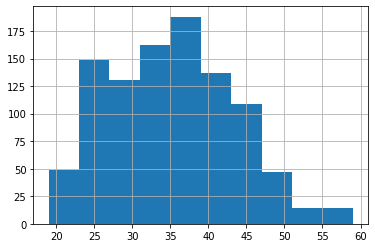

In [12]:
df['smooth-or-featured_featured-or-disk'].hist()

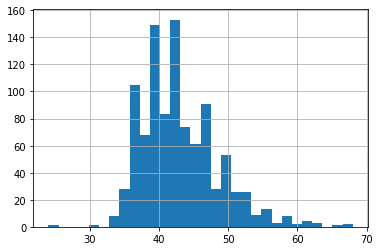

In [13]:
(df['smooth-or-featured_featured-or-disk'] + df['smooth-or-featured_smooth']).hist(bins=30)

(0.0, 1.0)

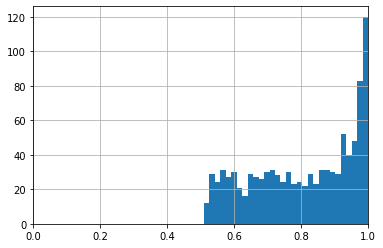

In [14]:
(df['smooth-or-featured_featured-or-disk'] / (df['smooth-or-featured_featured-or-disk'] + df['smooth-or-featured_smooth'])).hist(bins=30)
plt.xlim(0., 1.)

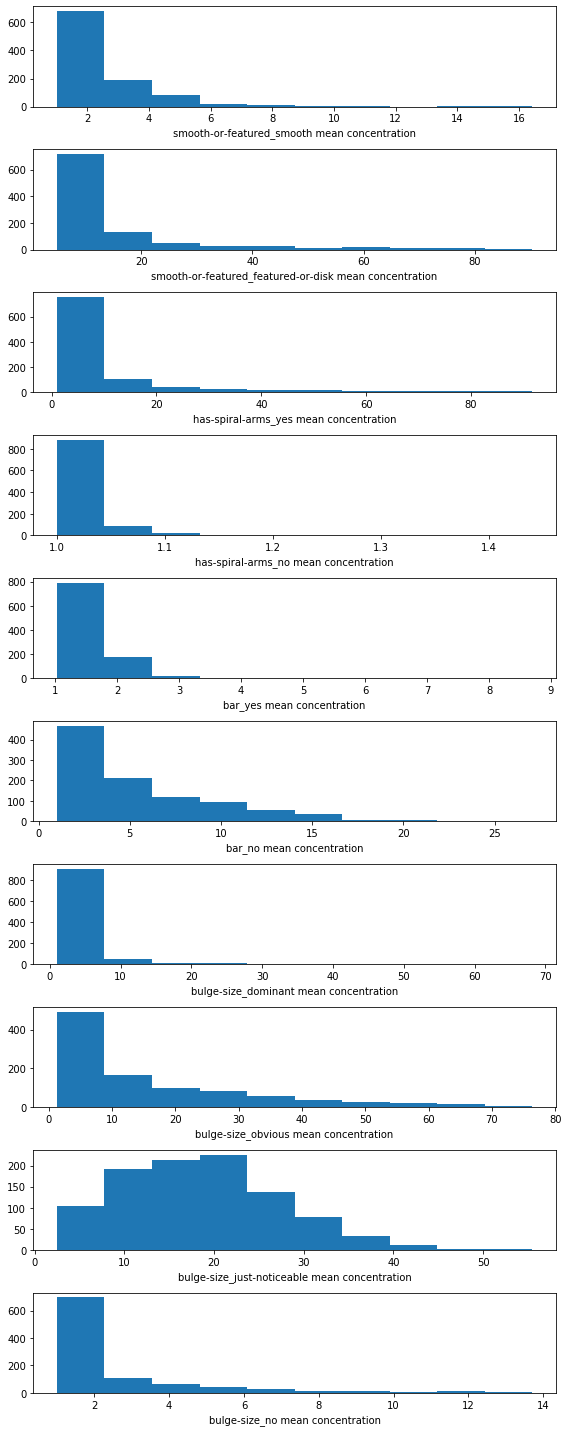

In [15]:
fig, axes = plt.subplots(nrows=len(schema.answers), figsize=(8, 20))
for n, a in enumerate(schema.answers):
    ax = axes[n]
    ax.hist(df[a.text + '_concentration_mean'])
    ax.set_xlabel(a.text + ' mean concentration')
fig.tight_layout()

In [16]:
df['smooth-or-featured_smooth_concentration_mean']

0      1.497396
1      2.033289
2      1.061700
3      4.839411
4      5.226100
         ...   
995    3.299746
996    3.561925
997    1.957119
998    1.740157
999    1.737701
Name: smooth-or-featured_smooth_concentration_mean, Length: 1000, dtype: float64

In [17]:
df['smooth-or-featured_featured-or-disk_concentration_mean']

0       7.051013
1      10.578156
2      79.519417
3      11.092157
4      12.197025
         ...    
995     8.144781
996     8.948215
997     7.109443
998     7.834960
999    11.085878
Name: smooth-or-featured_featured-or-disk_concentration_mean, Length: 1000, dtype: float64

In [18]:
df['has-spiral-arms_yes_concentration_mean']

0       7.930334
1       2.556793
2      85.030739
3       4.275655
4       1.078730
         ...    
995     1.704650
996     5.006871
997     6.601831
998     6.371815
999     2.682082
Name: has-spiral-arms_yes_concentration_mean, Length: 1000, dtype: float64

In [19]:
df['has-spiral-arms_no_concentration_mean']

0      1.009068
1      1.014334
2      1.014821
3      1.141370
4      1.049573
         ...   
995    1.020067
996    1.078387
997    1.013343
998    1.008188
999    1.008832
Name: has-spiral-arms_no_concentration_mean, Length: 1000, dtype: float64

In [20]:
# df['bar_strong_concentration_mean']

In [21]:
# df['bar_weak_concentration_mean']

In [22]:
df['bar_no_concentration_mean']

0       1.978654
1       1.705628
2      13.259984
3      15.541064
4       2.147201
         ...    
995     2.454560
996     8.084125
997     6.352884
998     4.979966
999     2.458787
Name: bar_no_concentration_mean, Length: 1000, dtype: float64

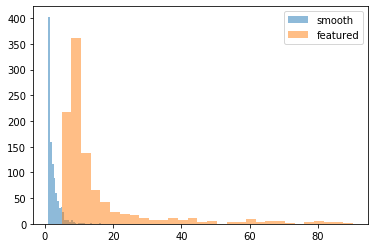

In [23]:
fig, ax = plt.subplots()
ax.hist(df['smooth-or-featured_smooth_concentration_mean'], bins=30, alpha=.5, label='smooth')
ax.hist(df['smooth-or-featured_featured-or-disk_concentration_mean'], bins=30, alpha=.5, label='featured')
# plt.xlim(0., 1.)
plt.legend()

In [24]:


samples = np.array([df[a.text + '_concentration'] for a in schema.answers]).transpose(1, 0, 2)
# dirichlet_prob_of_answers()
print(samples.shape)

(1000, 10, 10)


In [32]:
question = schema.get_question('smooth-or-featured')
# question = schema.get_question('has-spiral-arms')
# question = schema.get_question('bar')
answer = question.answers[0]

In [33]:
answer.text

'smooth-or-featured_smooth'

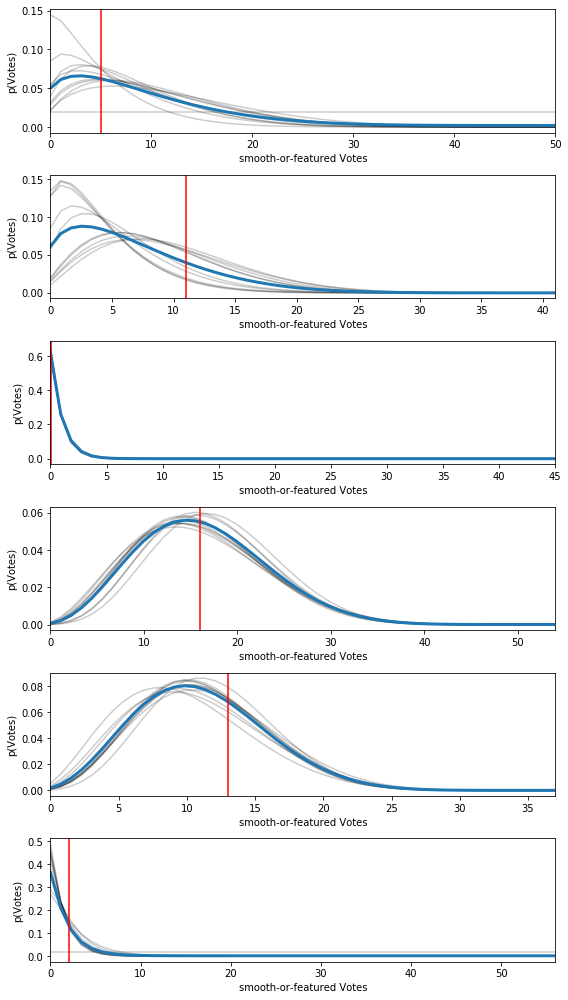

In [43]:

fig, axes = plt.subplots(nrows=6, figsize=(8, 14))
for n in range(6):
    
    ax = axes[n]
    
    galaxy = df.iloc[n]
    total_votes = float(galaxy[question.text+'_total-votes'])
    
    votes = np.linspace(0., total_votes)
    x = np.stack([votes, total_votes-votes], axis=-1)  # also need the counts for other answer, no
    votes_this_answer = x[:, answer.index - question.start_index]

    all_log_probs = []
    for d in range(10):
        concentrations = tf.constant(samples[n, question.start_index:question.end_index+1, d].astype(np.float32))
        log_probs = tfp.distributions.DirichletMultinomial(total_votes, concentrations).prob(x)
        all_log_probs.append(log_probs)
        ax.plot(votes_this_answer, log_probs, alpha=.2, color='k')
    all_log_probs = np.array(all_log_probs).mean(axis=0)
    ax.plot(votes_this_answer, all_log_probs, linewidth=3.)
    ax.axvline(df[answer.text].iloc[n]+0.03, color='r')
    ax.set_xlim(0., total_votes)
    ax.set_xlabel(question.text + ' Votes')
    ax.set_ylabel('p(Votes)')
fig.tight_layout()

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


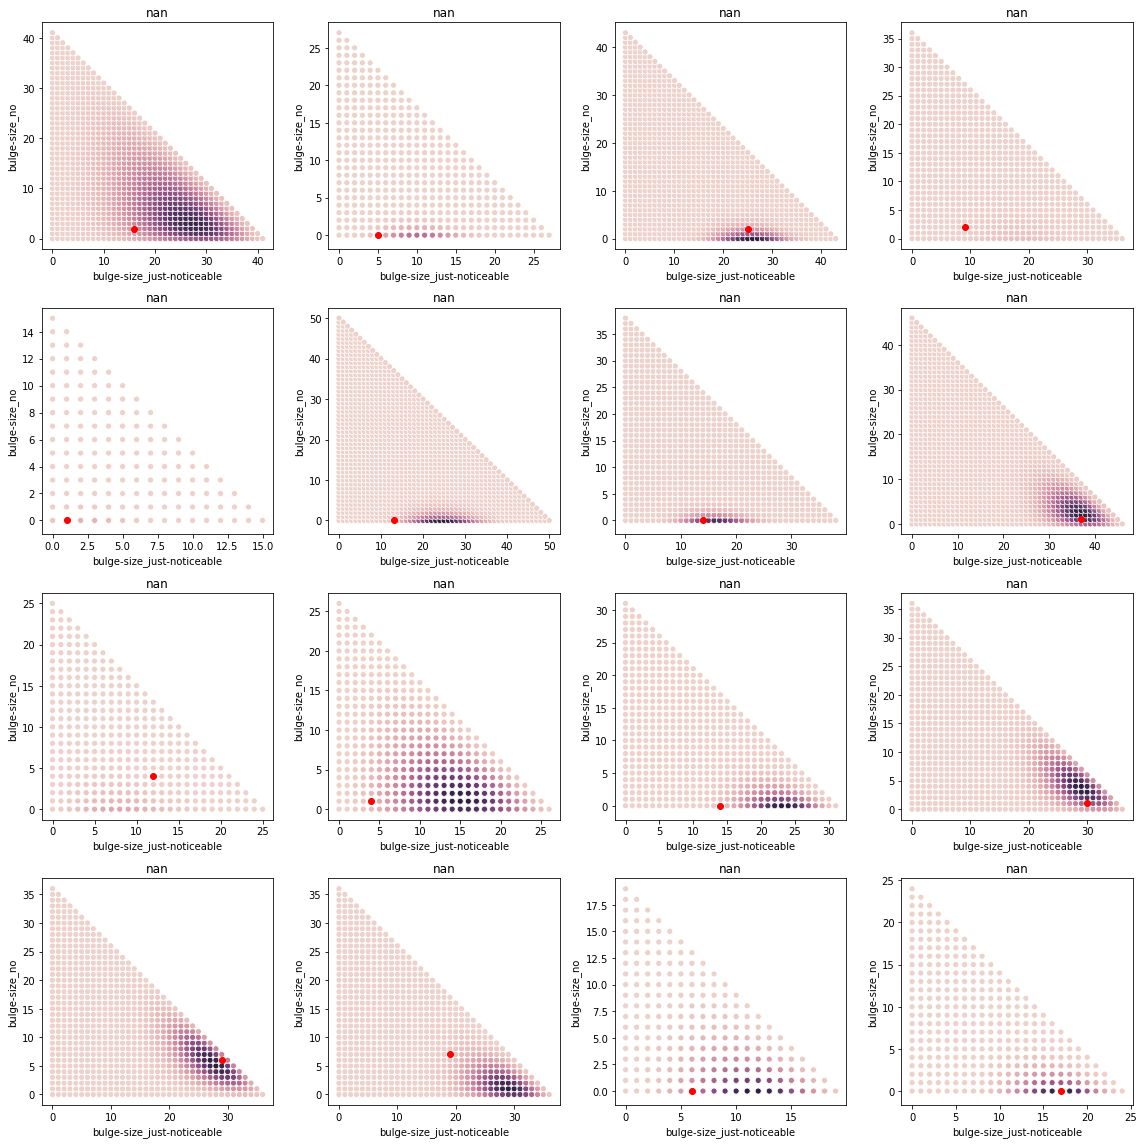

In [29]:
# question = schema.get_question('bar')
question = schema.get_question('bulge-size')
answer = question.answers[0]

total_galaxies = 16

answer_a_index = 2
answer_b_index = 3

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
all_axes = [ax for row in axes for ax in row]
for n in range(total_galaxies):
    ax = all_axes[n]

    galaxy = df.iloc[n]
    total_votes = int(galaxy[question.text+'_total-votes'])
    actual_votes = galaxy[[a.text for a in question.answers]].values
    
    permutations = np.array(get_discrete_permutations(total_votes, len(question.answers)))
#     permutations = np.array(list(partitions(total_votes, 3)))
    probs = np.zeros((len(permutations), 15))
    for d in range(10):
        concentrations = tf.constant(samples[n, question.start_index:question.end_index+1, d].astype(np.float32))
        probs[:, d] = tfp.distributions.DirichletMultinomial(total_votes, concentrations).prob(permutations)
    sns.scatterplot(permutations[:, answer_a_index], permutations[:, answer_b_index], hue=probs.mean(axis=1), ax=ax, legend=False)
    
    entropy = np.sum(-probs * np.log(probs))
    ax.set_title(np.around(entropy, 3))
    
    ax.scatter(x=actual_votes[answer_a_index], y=actual_votes[answer_b_index], color='r')
    ax.set_xlabel(question.answers[answer_a_index].text)
    ax.set_ylabel(question.answers[answer_b_index].text)
    
fig.tight_layout()


In [ ]:
_ = show_galaxies(df.sample(100), ncols=5, nrows=5)

In [ ]:
_ = show_galaxies(df[df['smooth-or-featured_featured-or-disk_prediction_mean'] > 0.45].sample(100), ncols=6, nrows=6)

In [ ]:
df.columns.values

In [ ]:
feat = df[df['smooth-or-featured_featured-or-disk_prediction_mean'] > 0.5]
(feat['disk-edge-on_yes'] / feat['smooth-or-featured_featured-or-disk']).hist(bins=30)

In [ ]:
# b = (feat['disk-edge-on_yes'] / feat['smooth-or-featured_featured-or-disk']) < 0.5
# face = feat[b]
# edge = feat[~b]

In [ ]:
# edge

In [ ]:
# _ = show_galaxies(edge.sample(100), ncols=6, nrows=6)

In [ ]:
_ = show_galaxies(face.sample(100), ncols=6, nrows=6)

In [ ]:
# df['disk-edge-on_yes_prediction_mean_dummy'] = df['disk-edge-on_yes'] / df['smooth-or-featured_featured-or-disk']
# df.to_csv('temp/smooth_or_featured_labelled_latest_with_edge.csv', index=False)

In [ ]:

def get_single_answer_data(df, answer, n=10):
    samples = np.stack(df[answer.text + '_prediction'][:n])
    labels = df[answer.text][:n].values.astype(int)
    total_votes = df[answer.question.text + '_total-votes'][:n].values.astype(int)
    return samples, labels, total_votes
    

In [ ]:
def show_population_stats(samples, labels, total_votes, title):
    # sns.set_context('paper')
    sns.set(font_scale=1.)
    sns.set_style('white')
    alpha = 0.5
    # matplotlib.rcParams.update({'font.size': 50}
    
    mean_samples = samples.mean(axis=-1)
    expected_k = mean_samples * total_votes

    # dummy for bins
    fig, (ax0, ax1) = plt.subplots(nrows=2)
    _, bins_rho, _ = ax0.hist(labels/ total_votes, bins=25, alpha=alpha, label='Actual')
    _, bins_k, _ = ax1.hist(labels, bins=25, alpha=alpha, label='Actual')
    plt.close()

    # now for real
    fig, (ax0, ax1) = plt.subplots(nrows=2)

    _, bins, _ = ax0.hist(mean_samples, bins=bins_rho, alpha=alpha, label='Model')
    ax0.hist(labels/ total_votes, bins=bins_rho, alpha=alpha, label='Actual')
    ax0.set_xlabel(r'Vote Fraction $\rho$')
    ax0.set_ylabel('Galaxies')
    ax0.legend()
    ax0.set_xlim([0., 1.])

    _, bins, _ = ax1.hist(expected_k, bins=bins_k, alpha=alpha, label='Model')
    ax1.hist(labels, bins=bins_k, alpha=alpha, label='Actual')
    ax1.set_xlabel(r'Positive Responses $k$')
    ax1.set_ylabel('Galaxies')
    ax1.legend()
    ax1.set_xlim([0, 40])

    ax0.set_title(title)
    fig.tight_layout()
    return fig
    # fig.savefig(os.path.join(save_dir, 'posterior_over_full_sample.png'))
    # fig.savefig(os.path.join(save_dir, 'posterior_over_full_sample.pdf'))

In [ ]:

answer = schema.get_answer('smooth-or-featured_smooth')
samples, labels, total_votes = get_single_answer_data(df, answer, n=len(df))
_ = show_population_stats(samples, labels, total_votes, answer.text)

In [ ]:
for answer in schema.answers:
    samples, labels, total_votes = get_single_answer_data(df, answer, n=len(df))
    fig = show_population_stats(samples, labels, total_votes, answer.text)
#     fig.savefig(save_dir + '/population_distribution_' + answer.text + '.png')

In [ ]:
def custom_samples(samples, labels, total_votes):
    sns.set_context('paper', font_scale=1.5)
    fig, axes = plt.subplots(nrows=len(labels), figsize=(3, len(labels)*1.5), sharex=True)
    make_predictions.plot_samples(samples, labels, total_votes, fig, axes, alpha=0.1)
    for ax in axes:
        ax.set_xlim([0, 40])
    
    for n in range(len(labels)):
#         axes[n].set_ylabel(r'$p(v|D)$', visible=True)
        axes[n].set_ylabel(r'$p(v|w)$', visible=True)
        axes[n].yaxis.set_visible(True)
    
    axes[-1].set_xlabel('Volunteer Votes')
    fig.tight_layout()

    axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )
    fig.tight_layout()
    return fig

In [ ]:

question = schema.get_question('smooth-or-featured')
answer = schema.get_answer(question.text +'_smooth')
n = 5
samples, labels, total_votes = get_single_answer_data(df, answer, n)
_ = custom_samples(samples, labels, total_votes)

In [ ]:

question = schema.get_question('has-spiral-arms')
answer = schema.get_answer(question.text + '_yes')
n = 5
samples, labels, total_votes = get_single_answer_data(df, answer, n)
_ = custom_samples(samples, labels, total_votes)

In [ ]:
def plot_galaxy(image_loc, ax, n_examples=10, crop=0):
    im_size = 424
    im = Image.open(image_loc)
#     if QUESTION == 'bars':
#         crop = 120
#     else:
    crop = 35
    cropped_im = im.crop((crop, crop, 424 - crop, 424 - crop))
    ax.imshow(cropped_im)
    ax.grid(False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)


In [ ]:

def galaxy_posterior_grid(df, schema):
    
    sns.set_context('paper', font_scale=1.5)
    
    scale = 1.5
    
    im_width = 2
    posterior_width = 3
    height = im_width
    
    n_galaxies = len(df)
    n_posteriors = len(schema.answers)
    
    fig = plt.figure(figsize=(scale * (im_width + posterior_width*n_posteriors), (scale * n_galaxies * height)))  # width, height format
    gs = gridspec.GridSpec(len(df) * height, im_width + posterior_width * len(schema.answers))  # y, x format
    image_axes = []
    posterior_axes = []  # (galaxy i.e. row, answer) shape
    
    # create the grid
    for galaxy_n in range(len(df)):
        y_slice = slice(galaxy_n*height, (galaxy_n+1)*height)
        image_axes.append(plt.subplot(gs[y_slice, :im_width]))
        
        temp_galaxy_axes = []
        for answer_n, answer in enumerate(schema.answers):
            x_slice = slice(im_width+answer_n*posterior_width, im_width+(answer_n+1)*posterior_width)
            temp_galaxy_axes.append(plt.subplot(gs[y_slice, x_slice]))
        posterior_axes.append(temp_galaxy_axes)
        
    
    # fill the images
    for ax_n, ax in enumerate(image_axes):
        plot_galaxy(df['file_loc'][ax_n], ax)
    
    # fill the posteriors
    for answer_n, answer in enumerate(schema.answers):
        samples, labels, total_votes = get_single_answer_data(df, answer)
        galaxy_axes = [axes[answer_n] for axes in posterior_axes]
        make_predictions.plot_samples(samples, labels, total_votes, fig, galaxy_axes, alpha=0.06)
    
    # fix x limits for comparison
    for row_n, axes in enumerate(posterior_axes):
        for answer_n, ax in enumerate(axes):
            ax.set_xlim([0, 50])
            if row_n == 0:
                ax.set_title(schema.answers[answer_n].text)
    
    fig.tight_layout()
    return fig

In [ ]:
fig = galaxy_posterior_grid(df[:10], schema)
save_dir = 'results'
# fig.savefig(save_dir + '/grid.pdf')
# fig.savefig(save_dir + '/grid.png')

## Show successes and failures